In [1]:
import os
import cmocean
import hikinggc
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import subprocess
import json
import warnings
import matplotlib.cbook
import rasterio
import cmcrameri
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
import datetime
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
from matplotlib.colors import LightSource
import matplotlib as mpl
mpl.style.use("./hiking.mplstyle")
lpcoords = (-18.0725, -17.6983, 28.4385, 28.8591)

In [30]:
lapalma = hikinggc.Island(bbox=lpcoords)
from shapely.geometry import shape
from shapely.geometry import Polygon
from matplotlib.collections import PatchCollection
import json
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from descartes import PolygonPatch
from matplotlib.font_manager import FontProperties
fontfile = "/home/ctroupin/.fonts/D-DIN.ttf"
myfont = FontProperties(fname=fontfile)

In [31]:
earthquake = os.path.join(hikinggc.datadir, "Volcan/catalogoComunSV_1632492892997.csv")
topofile = os.path.join(hikinggc.datadir, '136_MDT25_LP.tif')

## Read data
### Topography

In [32]:
topography = hikinggc.Topography()
topography.read_geotiff(topofile)
topography.image = np.ma.masked_less_equal(topography.image, 0.)

### Earthquake

In [33]:
dataearthquake = pd.read_csv(earthquake, delimiter=";")

lone = dataearthquake['    Longitud'].values
late = dataearthquake['     Latitud'].values
magnitude = dataearthquake['        Mag.'].values

### Lava contours

In [34]:
def read_json_polygon(datafile):
    with open(datafile, "r") as df:
        data = json.load(df)
    coords = data['features'][0]['geometry']['coordinates'][0]
    polygon = Polygon(coords[0], [coords[1]])
    return polygon

In [35]:
polygon01 = read_json_polygon("../Data/Volcan/Volcan01.geojson")
polygon02 = read_json_polygon("../Data/Volcan/Volcan02.geojson")
polygon03 = read_json_polygon("../Data/Volcan/Volcan03.geojson")
polygon04 = read_json_polygon("../Data/Volcan/Volcan04.geojson")

### Fires

In [36]:
fire1 = pd.read_csv("../Data/Fires/LaPalma/DL_FIRE_SV-C2_224791/fire_nrt_SV-C2_224791.csv", delimiter=",")
fire2 = pd.read_csv("../Data/Fires/LaPalma/DL_FIRE_J1V-C2_224790/fire_nrt_J1V-C2_224790.csv", delimiter=",")
fire3 = pd.read_csv("../Data/Fires/LaPalma/DL_FIRE_M-C61_224789/fire_nrt_M-C61_224789.csv", delimiter=",")

## Make plot

In [37]:
cmap = plt.cm.gray
ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(topography.image, cmap=cmap, blend_mode='soft',
               vert_exag=0.05)

# Transform rgb to gray scale, so we can use pcolormesh (imshow failing)
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

topogrey = rgb2gray(rgb)
# Mask outside land
topogrey = np.ma.masked_where(topography.image == topography.image.min(), topogrey) 

## Make the plot

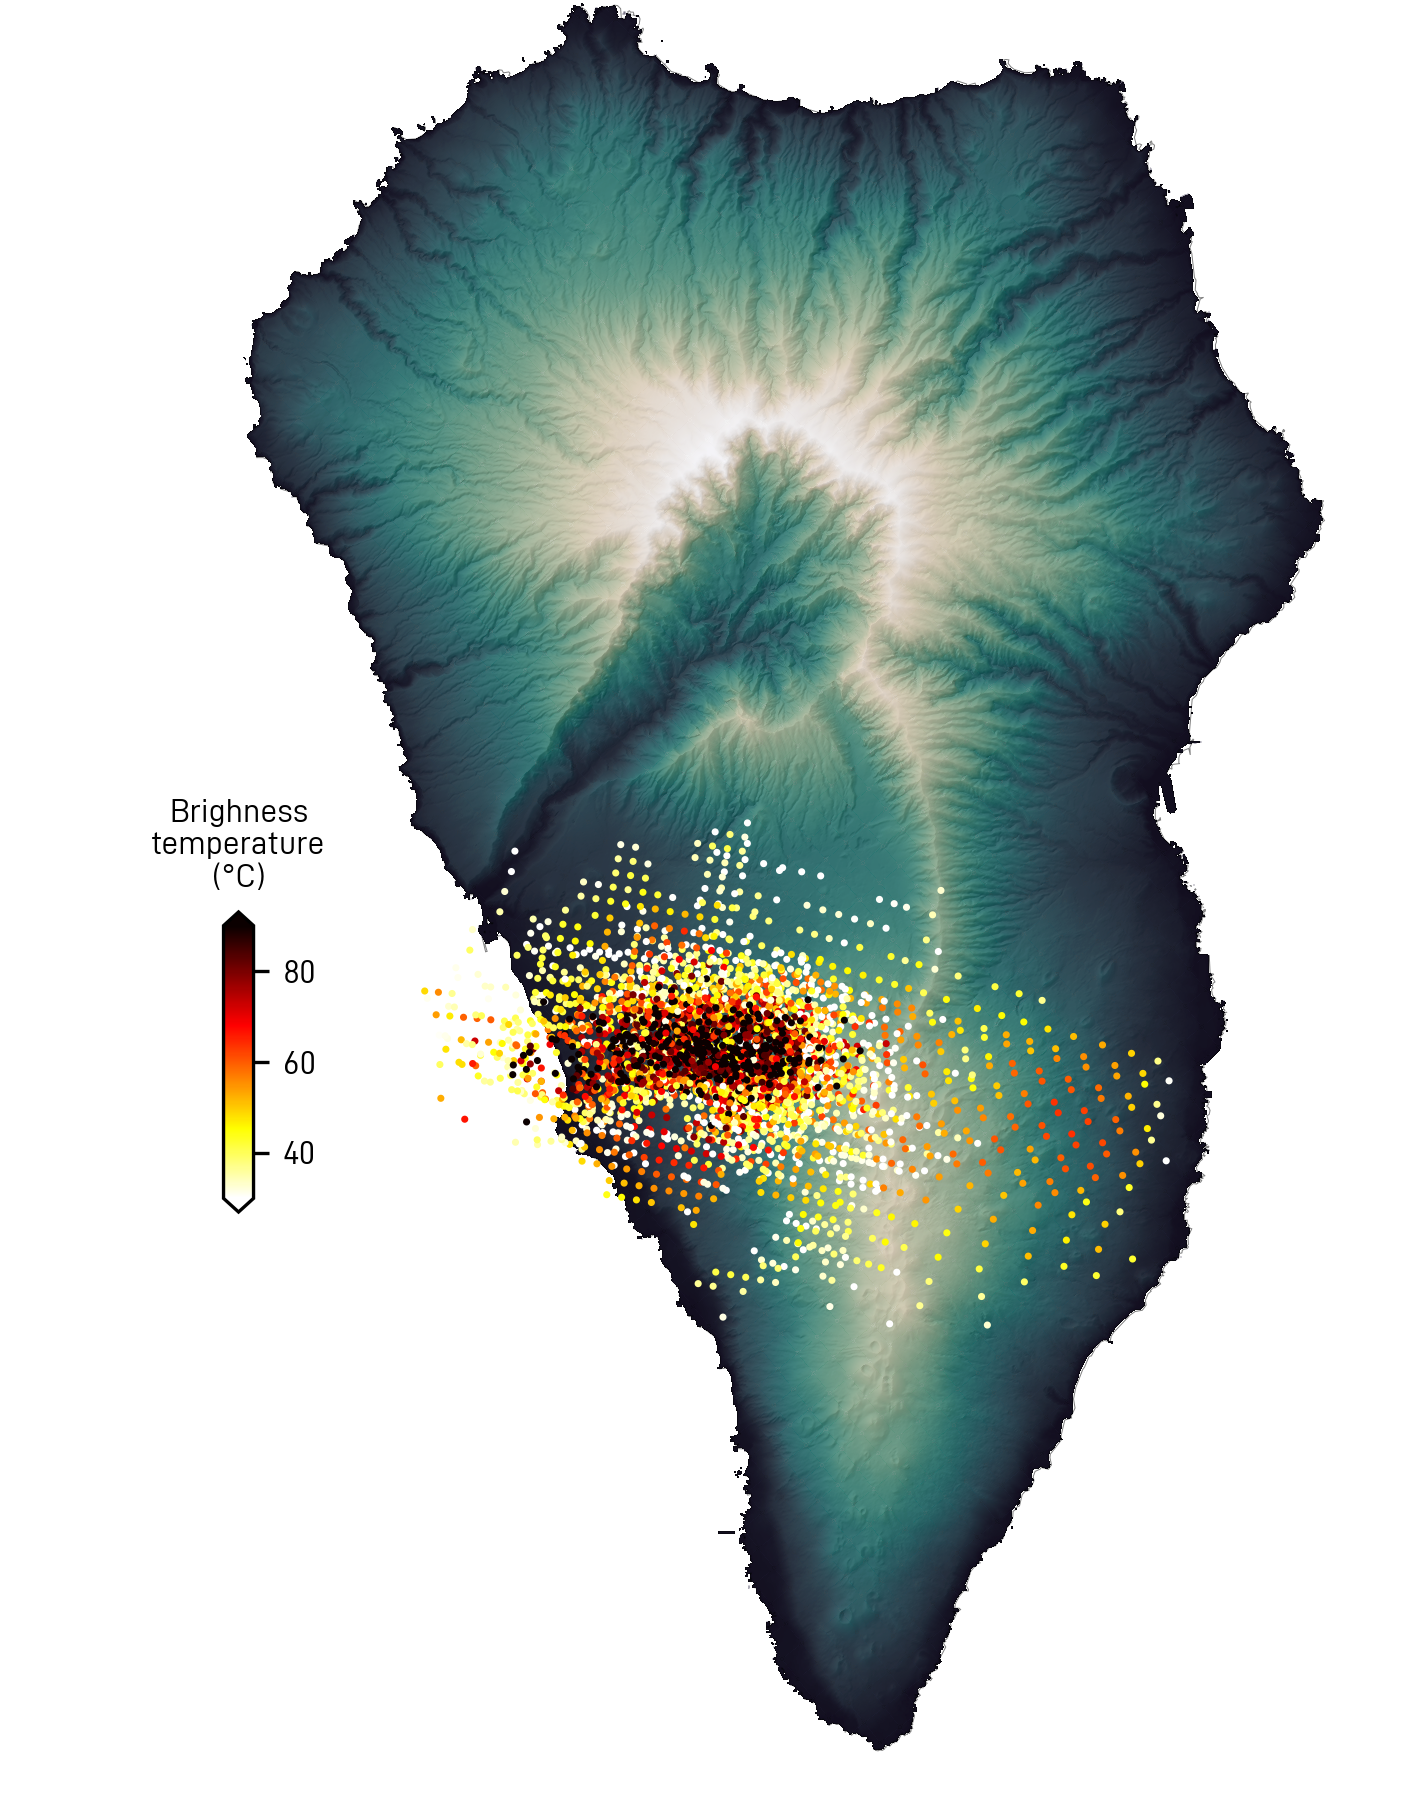

In [38]:
# plt.style.use('dark_background')

volcan_poly01 = PolygonPatch(polygon01, fc="#FFFA2F", ec="#FFFA2F", 
                           linewidth=.5, alpha=.7, transform=hikinggc.data_crs, zorder=10)
volcan_poly02 = PolygonPatch(polygon02, fc="#FF8902", ec="#FF8902", 
                           linewidth=.5, alpha=.7, transform=hikinggc.data_crs, zorder=9)
volcan_poly03 = PolygonPatch(polygon03, fc="r", ec="r", 
                           linewidth=.5, alpha=.7, transform=hikinggc.data_crs, zorder=8)
volcan_poly04 = PolygonPatch(polygon04, fc="r", ec="k", 
                           linewidth=.5, alpha=.75, transform=hikinggc.data_crs, zorder=7)

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection=lapalma.proj)

pcm = ax.pcolormesh(topography.lon, topography.lat, topography.image, vmax=2400., 
                    cmap=cmocean.cm.rain_r, transform=ccrs.UTM(28), zorder=4, alpha=0.2)


shade = ax.pcolormesh(topography.lon, topography.lat, topogrey, cmap=plt.cm.gray,
          transform=ccrs.UTM(28), zorder=3, alpha=1)


#ax.add_patch(volcan_poly01)
#ax.add_patch(volcan_poly02)
#ax.add_patch(volcan_poly03)
# ax.add_patch(volcan_poly04)

## Fires (thermal anomalies
ax.scatter(fire1["longitude"], fire1["latitude"], s=.5, c=fire1["brightness"]- 273.15, vmin=30, vmax=90., 
           transform=hikinggc.data_crs, zorder=6, cmap=plt.cm.hot_r)
ax.scatter(fire2["longitude"], fire2["latitude"], s=.5, c=fire2["brightness"]- 273.15, vmin=30, vmax=90., 
           transform=hikinggc.data_crs, zorder=6, cmap=plt.cm.hot_r)
scatfire = ax.scatter(fire3["longitude"], fire3["latitude"], s=.5, c=fire3["brightness"]- 273.15, vmin=30, vmax=90., 
           transform=hikinggc.data_crs, zorder=6, cmap=plt.cm.hot_r)

cbar_ax2 = fig.add_axes([0.35, 0.375, 0.01, 0.125])
cb2 = plt.colorbar(scatfire, cax=cbar_ax2, extend="both")
cb2.solids.set(alpha=1)
cb2.ax.tick_params(labelsize=8)
cb2.ax.set_title("Brighness\ntemperature\n(°C)", fontsize=8, fontproperties=myfont)
for t in cb2.ax.get_yticklabels():
    t.set_font_properties(myfont)
        

"""
scat1 = ax.scatter(lone, late, s=4, c=magnitude, cmap=plt.cm.inferno_r, marker="x",
           transform=hikinggc.data_crs, zorder=7, alpha=.5, vmin=1., vmax=4.)


cbar_ax = fig.add_axes([0.15, 0.175, 0.01, 0.125])
cb1 = plt.colorbar(scat1, cax=cbar_ax, extend="both")
cb1.solids.set(alpha=1)
cb1.set_ticks([1., 2., 3., 4.])
cb1.ax.tick_params(labelsize=8)
"""
ax.set_extent(lpcoords)
# ax.set_extent([-17.953, -17.825, 28.58, 28.67])
ax.spines['geo'].set_color("w")
ax.add_wms(wms='http://ows.emodnet-bathymetry.eu/wms', layers=['coastlines'])
#cb = plt.colorbar(pcm, shrink=.8)
#cb.set_ticks(np.arange(0, 2500, 500))
#cb.set_label('(m)', fontsize=14, rotation=0, ha="left")
plt.savefig(os.path.join(hikinggc.figdir, "LaPalma_firesV8_dark.png"))
plt.show()
plt.close()

In [16]:
ax.coastlines?


## Animation
### Parse the dates

In [18]:
datelist1, datelist2, datelist3 = [], [], []
for dd, hh in zip(fire1["acq_date"], fire1["acq_time"]):
    thedate = datetime.datetime.strptime(dd, '%Y-%m-%d')
    thetime = datetime.datetime.strptime(str(hh).zfill(4), '%H%M')
    datelist1.append(datetime.datetime(thedate.year, thedate.month, thedate.day, thetime.hour, thetime.minute))
for dd, hh in zip(fire2["acq_date"], fire2["acq_time"]):
    thedate = datetime.datetime.strptime(dd, '%Y-%m-%d')
    thetime = datetime.datetime.strptime(str(hh).zfill(4), '%H%M')
    datelist2.append(datetime.datetime(thedate.year, thedate.month, thedate.day, thetime.hour, thetime.minute))

for dd, hh in zip(fire3["acq_date"], fire3["acq_time"]):
    thedate = datetime.datetime.strptime(dd, '%Y-%m-%d')
    thetime = datetime.datetime.strptime(str(hh).zfill(4), '%H%M')
    datelist3.append(datetime.datetime(thedate.year, thedate.month, thedate.day, thetime.hour, thetime.minute))

# Create arrays
datelist = np.array(datelist1 + datelist2 + datelist3)
datelist1 = np.array(datelist1)
datelist2 = np.array(datelist2)
datelist3 = np.array(datelist3)

In [ ]:
datesuniq = np.unique(datelist)
iii = 0
for dd in datesuniq:
    iii += 1
    gooddate1 = np.where(datelist1 <= dd)[0]
    gooddate2 = np.where(datelist2 <= dd)[0]
    gooddate3 = np.where(datelist3 <= dd)[0]
    # print(len(gooddate1), len(gooddate2), len(gooddate3))
    
    fig = plt.figure(figsize=(10, 8))

    ax = plt.subplot(111, projection=lapalma.proj)
    
    ax.text(.05, 0.95, dd, fontsize=20, ha="left", va="top", transform = ax.transAxes, fontproperties=myfont)

    pcm = ax.pcolormesh(topography.lon, topography.lat, topography.image, vmax=2400., 
                        cmap=cmocean.cm.rain_r, transform=ccrs.UTM(28), zorder=4, alpha=0.2)


    shade = ax.pcolormesh(topography.lon, topography.lat, topogrey, cmap=plt.cm.gray,
              transform=ccrs.UTM(28), zorder=3, alpha=1)

    ax.scatter(fire1["longitude"][gooddate1], fire1["latitude"][gooddate1], s=.2, 
               c=fire1["brightness"][gooddate1]- 273.15, vmin=30, vmax=90., 
           transform=hikinggc.data_crs, zorder=6, cmap=plt.cm.hot_r)
    ax.scatter(fire2["longitude"][gooddate2], fire2["latitude"][gooddate2], s=.2, 
               c=fire2["brightness"][gooddate2]- 273.15, vmin=30, vmax=90., 
               transform=hikinggc.data_crs, zorder=6, cmap=plt.cm.hot_r)
    scatfire = ax.scatter(fire3["longitude"][gooddate3], fire3["latitude"][gooddate3], s=.2, 
                          c=fire3["brightness"][gooddate3]- 273.15, vmin=30, vmax=90., 
               transform=hikinggc.data_crs, zorder=6, cmap=plt.cm.hot_r)

    cbar_ax2 = fig.add_axes([0.35, 0.375, 0.01, 0.125])
    cb2 = plt.colorbar(scatfire, cax=cbar_ax2, extend="both")
    cb2.solids.set(alpha=1)
    cb2.ax.tick_params(labelsize=8)
    cb2.ax.set_title("Brighness\ntemperature\n(°C)", fontsize=8, fontproperties=myfont)
    for t in cb2.ax.get_yticklabels():
        t.set_font_properties(myfont)


    ax.set_extent(lpcoords)
    # ax.set_extent([-17.953, -17.825, 28.58, 28.67])
    ax.spines['geo'].set_color("w")

    #cb = plt.colorbar(pcm, shrink=.8)
    #cb.set_ticks(np.arange(0, 2500, 500))
    #cb.set_label('(m)', fontsize=14, rotation=0, ha="left")
    plt.savefig(os.path.join(hikinggc.figdir, "fires20210930_{}".format(str(iii).zfill(3))))
    plt.close('all')